# Imports

In [1]:
import numpy as np
import numpy_financial as npf
import pandas as pd
from scipy.stats import weibull_min, uniform
import matplotlib.pyplot as plt
import seaborn as sns
import uuid
import kaleido
import plotly.express as px
import math
import random
import tqdm
import plotly.graph_objects as go
import os
from pathlib import Path

# File Paths

In [2]:
# Define paths for input and output data (customize these as needed for your dataroom setup)
INPUT_DIR = "/Users/smeden/Desktop/Lowe Syndrome Collaborative/Walther Therapeutics/git/Models/populationsdata"  # Directory containing input datasets
OUTPUT_DIR = "./output_data"  # Directory for storing results

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Input files
POPULATION_FILE = os.path.join(INPUT_DIR, "WPP2024_POP_F01_1_POPULATION_SINGLE_AGE_BOTH_SEXES.xlsx")
ISO_TO_REGION_FILE = os.path.join(INPUT_DIR, "iso_to_region.csv")
HDI_FILE = os.path.join(INPUT_DIR, "HDR23-24_Composite_indices_complete_time_series.csv")
FUTURE_POPULATION_FILE = os.path.join(INPUT_DIR, "WPP2024_Demographic_Indicators_Medium.csv")

# Population Model

This model simulates the incidence and distribution of a rare genetic disease among newborns across different countries over time. The model incorporates the relationship between the availability of genetic testing and economic development, where the Human Development Index (HDI) is used as a proxy for healthcare system capacity.

In [5]:
# Load population data 1950-2023, all countries, 1-year intervals
population = pd.read_excel(POPULATION_FILE, header=16)
population = population.loc[population.Type == "Country/Area"].reset_index()
iso_to_reg = pd.read_csv(ISO_TO_REGION_FILE)
population = population.merge(
    iso_to_reg[['alpha-3', 'region']], 
    left_on='ISO3 Alpha-code',
    right_on='alpha-3',
    how='left'
)

# Check the number of countries and years
print(f"Number of countries: {population['ISO3 Alpha-code'].nunique()}")
print(f"Number of years: {population['Year'].nunique()}")

# Additional checks
print(f"Number of rows: {population.shape[0]}")
print(f"Number of columns: {population.shape[1]}")

# Load HDI data 1990 - 2023 
hdi = pd.read_csv(HDI_FILE, encoding='latin1')

Number of countries: 237
Number of years: 74
Number of rows: 17538
Number of columns: 115


In [6]:
# Prepare future data
future_population = pd.read_csv(FUTURE_POPULATION_FILE)
future_population = future_population[["ISO3_code","ISO2_code","Time","Births"]]
future_population = future_population.loc[future_population.Time>2023]
future_population = future_population.rename(columns={
    'ISO3_code': 'ISO3 Alpha-code',
    'ISO2_code': 'ISO2 Alpha-code', 
    'Time': 'Year',
    'Births': 0
})

# Add future population data to population dataframe
population = pd.concat([population, future_population], ignore_index=True)

# Sort by country and year to ensure chronological order
population = population.sort_values(['ISO3 Alpha-code', 'Year'])
static_columns = ['Variant', 'Region, subregion, country or area *', 'Notes', 
                 'Location code', 'SDMX code**', 'Type', 'region']
population[static_columns] = population.groupby('ISO3 Alpha-code')[static_columns].ffill()

# Print verification of merging
print(f"Data now spans years: {population['Year'].min()} - {population['Year'].max()}")
print(f"Number of countries: {population['ISO3 Alpha-code'].nunique()}")

/var/folders/gg/176d9m9d78n1sckp6xcdmv8r0000gn/T/ipykernel_4437/2496950421.py:2: DtypeWarning: Columns (2,3,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  future_population = pd.read_csv(FUTURE_POPULATION_FILE)


Data now spans years: 1950.0 - 2101.0
Number of countries: 237


# 1. HDI Integration and Projection
The model uses historical HDI data (1990-2022) and implements advanced projection methods:

- Pre-1956: Set to 0 (before Lowe syndrome was discovered)
- 1956-1990: Linear interpolation from minimum HDI to first available HDI value
- 1990-2022: Uses actual historical HDI data
- Post-2022: Projects HDI values using country-specific growth rates

In [7]:
# Get list of HDI columns for years 1990-2022
hdi_cols = [f'hdi_{year}' for year in range(1990, 2023)]

# Select iso3 column and all HDI columns
hdi = hdi[['iso3'] + hdi_cols]

# Merge HDI data with population data
population = population.merge(hdi, left_on='ISO3 Alpha-code', right_on='iso3', how='left')

# Adjust the list of HDI columns based on actual column names
hdi_cols = [col for col in hdi.columns if col.startswith('HDI_') or col.startswith('hdi_')]

# Fill missing HDI values with regional averages
for col in hdi_cols:
    # Calculate regional averages for current HDI year, except for NaN values
    regional_means = population.groupby('region')[col].mean()
    
    # For each region, fill NaN values with the regional average
    for region in population['region'].dropna().unique():
        region_mask = population['region'] == region
        region_mean = regional_means[region]
        population.loc[region_mask, col] = population.loc[region_mask, col].fillna(region_mean)

In [8]:
# ---------------------------------------------------------------------
# 1) HDI retrieval with interpolation
# ---------------------------------------------------------------------
def get_effective_hdi(row,
                     year_col='Year',
                     hdi_floor=0.15,
                     pre_discovery_year=1956,
                     reference_year=1992,
                     final_year=2022,
                     growth_rates=None):
    """
    Returns an HDI for row[year_col] with updated rules:
      1) If year < discovery_year => minimal discovery => returns 0
      2) If discovery_year <= year < reference_year => linear interpolation
      3) If 1990 <= year <= 2022 => use historical data
      4) If year > 2022 => project forward with country-specific growth rate
    """
    year = int(row[year_col])
    
    # Case 1: Before discovery
    if year < pre_discovery_year:
        return 0.0
        
    # Case 2: Between discovery and reference year
    if pre_discovery_year <= year < reference_year:
        total_years = reference_year - pre_discovery_year
        years_from_discovery = year - pre_discovery_year
        # Linear interpolation from hdi_floor to first available HDI
        first_hdi = row.get('hdi_1990', 0.5)  # fallback to 0.5 if missing
        return hdi_floor + (first_hdi - hdi_floor) * (years_from_discovery / total_years)
    
    # Case 3: Historical HDI data (1990-2022)
    if 1990 <= year <= final_year:
        hdi_col = f'hdi_{year}'
        return row.get(hdi_col, 0.5)  # fallback to 0.5 if missing
    
    # Case 4: Future projections
    if year > final_year:
        # Get base HDI value from 2022
        base_hdi = row.get('hdi_2022', 0.5)  # fallback to 0.5 if missing
        
        # Get country-specific growth rate (or default to global average)
        country_code = row['ISO3 Alpha-code']
        growth_rate = growth_rates.get(country_code, 0.005)  # default 0.5% annual growth
        
        # Calculate projected HDI
        years_forward = year - final_year
        projected_hdi = base_hdi * (1 + growth_rate) ** years_forward
        
        # Cap at 1.0 and floor at hdi_floor
        return min(1.0, max(hdi_floor, projected_hdi))

def calculate_hdi_growth_rates(df):
    """
    Calculates average annual HDI growth rates for each country from 1990-2022.
    Returns a dictionary with {country_code: growth_rate}.
    """
    growth_rates = {}
    
    for _, row in df.drop_duplicates('ISO3 Alpha-code').iterrows():
        country = row['ISO3 Alpha-code']
        
        # Get 1990 and 2022 HDI values
        hdi_1990 = row.get('hdi_1990')
        hdi_2022 = row.get('hdi_2022')
        
        if pd.notna(hdi_1990) and pd.notna(hdi_2022) and hdi_1990 > 0:
            # Calculate compound annual growth rate
            years = 2022 - 1990
            growth_rate = (hdi_2022 / hdi_1990) ** (1/years) - 1
            growth_rates[country] = growth_rate
        else:
            # Use global average or default if missing data
            growth_rates[country] = 0.005  # 0.5% default growth
    
    return growth_rates

# Calculate growth rates
hdi_growth_rates = calculate_hdi_growth_rates(population)

# Apply the function to get projection HDI values
population['projected_hdi'] = population.apply(
    lambda row: get_effective_hdi(
        row, 
        growth_rates=hdi_growth_rates
    ), 
    axis=1
)

In [13]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path

def plot_hdi_trends(population_df):
    # Calculate mean HDI by region and year
    hdi_trends = population_df.groupby(['region', 'Year'])['projected_hdi'].mean().reset_index()
    
    # Create the plot
    fig = px.line(hdi_trends, 
                  x='Year', 
                  y='projected_hdi',
                  color='region',
                  title='HDI Trends by Region (1950-2060)',
                  labels={'projected_hdi': 'Human Development Index (HDI)',
                         'Year': 'Year',
                         'region': 'Region'})
    
    # Update layout
    fig.update_layout(
        xaxis_title='Year',
        yaxis_title='Human Development Index (HDI)',
        yaxis_range=[0, 1],
        legend_title='Region',
        template='plotly_white',
        hovermode='x unified'
    )
    
    # Add a vertical line at 1956 (disease discovery)
    fig.add_vline(x=1956, line_dash="dash", line_color="red",
                  annotation_text="Disease Discovery", 
                  annotation_position="top right")
    
    # Save the figure
    output_dir = Path("./output_data")
    output_dir.mkdir(exist_ok=True)
    fig.write_html(output_dir / "hdi_trends.html")
    fig.update_layout(paper_bgcolor='rgba(0,0,0,0)')
    fig.write_image(output_dir / "hdi_trends.png")
    
    return fig
plot_hdi_trends(population)

# 2. Case Generation Model
The model uses a Zero-Inflated Poisson (ZIP) distribution to generate new cases:

### Parameters:
- Base incidence rate: 1/500,000 births -> Reported in litterature for Lowe Syndrome
- Zero-inflation probability: (1 - HDI) for each country
- Expected cases: Population_age0 * incidence_rate * (1 + HDI)

### The ZIP model accounts for:
- Underreporting in countries with lower HDI
- Complete absence of cases before the disease's discovery (1956)
- Increased detection rates in countries with higher HDI

For each generated case, the model simulates individual lifecycles using the Weibull distribution for survival modeling with:
- Shape parameter: 2.0 (defines the distribution's shape)
- Scale parameter: 40.0 (affects the average survival time)

The model tracks for each individual:
- Birth year
- Country of origin
- Survival status
- Current age

In [25]:
# ---------------------------------------------------------------------
# 2) Zero-inflated Poisson for new (age-0) cases
# ---------------------------------------------------------------------
def simulate_cases_for_row(row,
                           incidence_rate=1/500000,
                           disease_discovery_year=1956,
                           year_col='Year',
                           pop_col=0):
    """
    Row-level ZIP logic:
      - If year < discovery => 0
      - Otherwise HDI = get_effective_hdi(...)
        zero_infl_prob = 1 - HDI
        structural zero => random check
        otherwise Poisson( pop_age0 * incidence_rate * (1 + HDI) )
    Note: pop_col refers to the column with newborn population (default '0').
          multiply by 1000 if necessary, etc.
    """

    year = int(row[year_col])
    # Example: treat 'pop_col' column as *thousands* => multiply by 1000
    pop_age0 = row.get(pop_col, 0) * 1000  
    if pd.isna(pop_age0) or pop_age0 <= 0:
        return 0

    # If year < disease_discovery_year => 0
    if year < disease_discovery_year:
        return 0

    # get HDI
    hdi_current = row['projected_hdi']

    # zero-inflation
    zero_infl_prob = 1.0 - hdi_current
    zero_infl_prob = max(0.0, min(1.0, zero_infl_prob))

    # structural zero check
    if np.random.random() < zero_infl_prob:
        return 0

    # Poisson mean
    lam = pop_age0 * incidence_rate * (1.0 + hdi_current)
    return np.random.poisson(lam)

def simulate_cases_for_dataframe(population,
                                 incidence_rate=1/500000,
                                 disease_discovery_year=1956,
                                 year_col='Year',
                                 pop_col=0):
    """
    Applies simulate_cases_for_row to each row of 'population',
    stores the result in 'simulated_cases'.
    """
    df = population.copy()
    df['simulated_cases'] = df.apply(
        simulate_cases_for_row,
        axis=1,
        incidence_rate=incidence_rate,
        disease_discovery_year=disease_discovery_year,
        year_col=year_col,
        pop_col=pop_col
    )
    return df

In [26]:
# ---------------------------------------------------------------------
# 3) Individual survival with Weibull
# ---------------------------------------------------------------------
def draw_weibull_lifespan(shape=2.0, scale=28.0):
    """
    Draw a random lifetime T from Weibull(shape, scale),
    using NumPy's np.random.weibull which only uses the shape.
    We will multiply by the scale to incorporate the scale parameter.
    """
    raw = np.random.weibull(shape)
    T = scale * raw
    return T

def simulate_individuals_lifecycle(df_cases, 
                                   start_year, 
                                   end_year,
                                   shape=2.0,
                                   scale=55.0):
    """
    1) df_cases: a DataFrame with columns 'Year' and 'simulated_cases' 
       (the number of new cases for that year).
    2) For each year in [start_year, end_year], we do the following:
         - Add new individuals => each gets a (birth_year, death_age).
         - For each existing individual, we record (year, age, alive).
    3) Returns a 'timeline' DataFrame with columns:
         (year, individual_id, age, alive).
       If age >= death_age => not alive.
    """
    # Build a dictionary: { year -> new_cases_count }
    test = df_cases.loc[df_cases['simulated_cases']>0]
    new_cases_dict = {}
    all_pairs = set()  # store (country, region) pairs we see
    for idx, row in test.iterrows():
        c = row['ISO2 Alpha-code']
        r = row['region']
        y = row['Year']
        s = row['simulated_cases']
        iso3 = row['ISO3 Alpha-code']
        new_cases_dict[(c, r, y)] = (s, iso3)
        all_pairs.add((c, r))

    # 2) Master list of individuals
    # We store each as a dictionary: {id, country, region, birth_year, death_age}
    individuals_list = []

    # We will also store a timeline: year x individual => (age, alive)
    timeline_rows = []

    # 3) Loop through each simulation year
    for current_year in range(start_year, end_year+1):

        # A) For each (country, region), add new individuals if any
        for (country, region) in all_pairs:
            cases_data = new_cases_dict.get((country, region, current_year), (0, None))
            c_new = cases_data[0]
            iso3_code = cases_data[1]
            for _ in range(c_new):
                lifespan = draw_weibull_lifespan(shape, scale)
                patient_id = str(uuid.uuid4())  # generate a unique UUID
                individuals_list.append({
                    'patient_uuid': patient_id,
                    'country': country,
                    'region': region,
                    'birth_year': current_year,
                    'death_age': lifespan,
                    'iso3': iso3_code
                })

        # B) For each individual, check if they are alive in current_year
        for person in individuals_list:
            if person['birth_year'] > current_year:
                # not born yet
                continue
            age = current_year - person['birth_year']
            alive = (age < person['death_age'])
            timeline_rows.append({
                'year': current_year,
                'country': person['country'],
                'region': person['region'],
                'patient_uuid': person['patient_uuid'],
                'age': age,
                'alive': alive,
                'iso3': person['iso3']
            })

    timeline_df = pd.DataFrame(timeline_rows)
    return timeline_df

In [27]:
import numpy as np
import plotly.graph_objects as go
from scipy.stats import weibull_min
from pathlib import Path

def create_survival_curves(shape=2.0, scale=28.0, age_range=np.arange(0, 101)):
    """
    Create visualization of Weibull survival curves for Lowe Syndrome patients.
    
    Parameters:
    -----------
    shape : float
        Shape parameter of the Weibull distribution (default: 2.0)
    scale : float
        Scale parameter of the Weibull distribution (default: 30.0)
    age_range : numpy.ndarray
        Array of ages to evaluate the survival function (default: 0-100 years)
    """
    # Calculate survival probabilities
    survival_prob = 1 - weibull_min.cdf(age_range, shape, scale=scale)
    
    # Calculate hazard rates
    hazard_rate = (shape/scale) * (age_range/scale)**(shape-1)
    
    # Calculate median and mean survival times
    median_survival = scale * np.log(2)**(1/shape)
    mean_survival = scale * np.exp(np.log(2)/shape)
    
    # Create figure with secondary y-axis
    fig = go.Figure()
    
    # Add survival curve
    fig.add_trace(
        go.Scatter(
            x=age_range,
            y=survival_prob,
            name="Survival Probability",
            line=dict(color="blue", width=2)
        )
    )
    

    
    # Add vertical lines for median and mean survival
    fig.add_vline(
        x=median_survival,
        line_dash="dash",
        line_color="green",
        annotation_text=f"Median: {median_survival:.1f}",
        annotation_position="top right"
    )
    
    fig.add_vline(
        x=mean_survival,
        line_dash="dash",
        line_color="purple",
        annotation_text=f"Mean: {mean_survival:.1f}",
        annotation_position="bottom left"
    )
    
    # Update layout
    fig.update_layout(
        title="Weibull Survival Curves for Lowe Syndrome Patients",
        xaxis_title="Age (years)",
        yaxis_title="Survival Probability",
        yaxis2=dict(
            title="Hazard Rate",
            overlaying="y",
            side="right"
        ),
        showlegend=True,
        template="plotly_white",
        hovermode="x unified"
    )
    
    # Create output directory if it doesn't exist
    output_dir = Path("./output_data")
    output_dir.mkdir(exist_ok=True)
    
    # Save the figure
    fig.write_html(output_dir / "survival_curves.html")
    fig.update_layout(paper_bgcolor='rgba(0,0,0,0)')
    fig.write_image(output_dir / "survival_curves.png")
    
    return fig

if __name__ == "__main__":
    # Create and display the survival curves
    fig = create_survival_curves()
    fig.show()

In [31]:
# ---------------------------------------------------------------------
# Simulation Run
# ---------------------------------------------------------------------
print("Running simulation...")

# 1) Run zero-inflated Poisson to get 'simulated_cases'
df_simulated = simulate_cases_for_dataframe(population, incidence_rate=1/500000)

# 2) Now simulate individuals from year=1955 to year=2060
timeline = simulate_individuals_lifecycle(
    df_cases=df_simulated, 
    start_year=1955, 
    end_year=2060,
    shape=2.0,
    scale=28.0
)

Running simulation...


In [ ]:
# Export timeline dataframe to csv
# Export full timeline
output_path = "/Users/smeden/Desktop/Lowe Syndrome Collaborative/Walther Therapeutics/git/Models/populationsdata/Simulated_ls_pop_1950_2060.csv"
timeline.to_csv(output_path, index=False)




In [ ]:
import pandas as pd
timeline = pd.read_csv("/Users/smeden/Desktop/Lowe Syndrome Collaborative/Walther Therapeutics/git/Models/populationsdata/Simulated_ls_pop_1950_2060.csv")

# Get 2024 patients by country
patients_by_country = timeline[
    (timeline['year'] == 2024) & 
    (timeline['alive'] == True)
].drop_duplicates('patient_uuid').groupby(['iso3', 'country_name', 'region']).size().reset_index(name='patients')

# Sort by region and number of patients
patients_by_country = patients_by_country.sort_values(['region', 'patients'], ascending=[True, False])

# Save to CSV
patients_by_country.to_csv("/Users/smeden/Desktop/Lowe Syndrome Collaborative/Walther Therapeutics/git/Models/populationsdata/patients_by_country_2024.csv", index=False)

# Print results
print("\nPatients by country in 2024:")
print(patients_by_country[['country_name', 'iso3', 'region', 'patients']])

# Print regional totals
print("\nRegional totals:")
regional_totals = patients_by_country.groupby('region')['patients'].sum().reset_index()
print(regional_totals)
#regional_totals.to_csv(output_dir / "regional_totals_2024.csv", index=False)

print("\nTotal patients:", regional_totals['patients'].sum())

KeyError: 'country_name'

In [32]:
# Analyze current patients by region
print("Patients alive in 2025 by region:")
timeline.loc[(timeline.alive == True) & (timeline.year==2025)].groupby("region").alive.count()

Patients alive in 2025 by region:


region
Africa      1438
Americas     999
Asia        4083
Europe       542
Oceania       37
Name: alive, dtype: int64

In [33]:
# Calculate total patients alive
total_alive = timeline.loc[(timeline.alive == True) & (timeline.year==2025)].groupby("region").alive.count().sum()
print(f"Total patients alive in 2025: {total_alive:,}")

Total patients alive in 2025: 7,099


# # 3. Approval waves

Wave 1 (2030):

USA and EU/EEA countries
Immediate access upon approval


Wave 2 (2033):

Australia, Canada, Brazil, South Korea, Taiwan, Japan
3 year delay from initial approval


Wave 3 (2032):

Saudi Arabia, Israel, UAE, Switzerland
2 year delay from initial approval

In [71]:
   print(timeline.columns)

Index(['year', 'country', 'region', 'patient_uuid', 'age', 'alive', 'iso3'], dtype='object')


In [72]:
# Define waves and their respective delays from US approval (using 2030 as base year)
WAVES = {
    'Wave 1': {
        'countries': ['USA'] + 
                    ['DEU', 'FRA', 'ITA', 'ESP', 'BEL', 'NLD', 'AUT', 'DNK', 'SWE', 'FIN', 'NOR', 'IRL', 'ISL', 'LIE',
                     'PRT', 'GRC', 'POL', 'CZE', 'HUN', 'SVK', 'SVN', 'EST', 'LVA', 'LTU', 'ROU', 'BGR', 'HRV', 'MLT', 'CYP', 'LUX'],  # All EU + EEA
        'delay': 0  # US + EU (about 1 year difference, but we treat it as same wave)
    },
    'Wave 2': {
        'countries': ['AUS', 'CAN', 'BRA', 'KOR', 'TWN', 'JPN'],  # Combining previous Wave 3 & 4
        'delay': 3  # ~3 years after US
    },
    'Wave 3': {
        'countries': ['SAU', 'ISR', 'ARE', 'CHE'],  # Saudi Arabia, Israel, UAE, Switzerland
        'delay': 2  # ~2 years after US
    }
}

# Function to analyze patients by wave
def analyze_waves(timeline_df, base_year=2030, end_year=2050):
    results = {}
    
    for wave_name, wave_info in WAVES.items():
        wave_start_year = base_year + wave_info['delay']
        
        # Filter for specific wave's countries and all years from wave start to end_year
        wave_patients = timeline_df[
            (timeline_df['iso3'].isin(wave_info['countries'])) &
            (timeline_df['year'].between(wave_start_year, end_year)) &
            (timeline_df['age'] < 21) &
            (timeline_df['alive'] == True)
        ]
        
        # Only keep unique patients (by patient_id) per wave
        unique_wave_patients = wave_patients.drop_duplicates(subset=['patient_uuid'])
        
        # Get region-specific counts of unique patients
        region_counts = unique_wave_patients.groupby('region').size()
        
        results[wave_name] = {
            'start_year': wave_start_year,
            'total_patients': len(unique_wave_patients),
            'region_counts': region_counts.to_dict(),
            'countries': wave_info['countries']
        }
    
    return results

# Run analysis
wave_results = analyze_waves(timeline)

# Create visualization
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
regions = ['Americas', 'Europe', 'Asia', 'Oceania', 'Africa']
waves = list(wave_results.keys())

# Create matrix of patient counts by region and wave
data = np.zeros((len(regions), len(waves)))
for i, wave in enumerate(waves):
    for j, region in enumerate(regions):
        data[j, i] = wave_results[wave]['region_counts'].get(region, 0)

# Set a nice color palette
colors = ['#2ecc71', '#3498db', '#9b59b6', '#f1c40f', '#e74c3c']

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bottom = np.zeros(len(waves))

bars = []
for i, region in enumerate(regions):
    bars.append(ax.bar(waves, data[i], bottom=bottom, label=region, color=colors[i]))
    
    # Add value annotations in the middle of each bar segment
    for j in range(len(waves)):
        if data[i][j] > 0:  # Only annotate if there are patients
            height = data[i][j]
            y_position = bottom[j] + height/2
            ax.text(j, y_position, f'{int(data[i][j]):,}', 
                   ha='center', va='center',
                   color='white' if colors[i] not in ['#f1c40f'] else 'black',  # Dark text for light colors
                   fontsize=9)
    bottom += data[i]

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

ax.set_title('Total Eligible Unique Patients by Wave and Region (2030-2050)')
ax.set_xlabel('Approval Wave')
ax.set_ylabel('Number of Unique Patients')
ax.legend()

plt.tight_layout()
plt.savefig('output_data/patient_distribution_by_region.png', transparent=True, bbox_inches='tight')
plt.close()

# Print detailed results
print("\nUnique Patient Distribution Across Approval Waves (2030-2050)")
print("-" * 70)
for wave, data in wave_results.items():
    print(f"\n{wave} (Starting Year {data['start_year']}):")
    print(f"Total unique patients under 21: {data['total_patients']}")
    print("Region counts:")
    for region, count in data['region_counts'].items():
        print(f"  {region}: {count} patients")


Unique Patient Distribution Across Approval Waves (2030-2050)
----------------------------------------------------------------------

Wave 1 (Starting Year 2030):
Total unique patients under 21: 1037
Region counts:
  Americas: 525 patients
  Asia: 2 patients
  Europe: 510 patients

Wave 2 (Starting Year 2033):
Total unique patients under 21: 490
Region counts:
  Americas: 294 patients
  Asia: 151 patients
  Oceania: 40 patients

Wave 3 (Starting Year 2032):
Total unique patients under 21: 122
Region counts:
  Asia: 117 patients
  Europe: 5 patients


# 4. Financial Model

This section models the financial aspects of the treatment rollout across different waves of countries.
Key components:
- Cost per treatment is set at 3M USD
- Market penetration rates increase over time:
- Year 1: 5% adoption
- Year 2: 20% adoption  
- Year 3: 40% adoption
- Year 4: 60% adoption
- Year 5+: 70% adoption
- Analysis runs from 2031-2050
- Only considers patients under 20 years
- Tracks cumulative treated patients to avoid double-counting
- Calculates yearly sales and patient numbers by country/wave

In [46]:
   def penetration_rate(years_since_approval):
        import numpy as np
        k = 1.5  # Steepness
        x0 = 2  # Midpoint
        max_rate = 0.4  # Maximum penetration rate
        
        # Sigmoid function scaled to max_rate
        rate = max_rate / (1 + np.exp(-k * (years_since_approval - x0)))
        return rate

   # Create figure showing penetration rate over first 10 years
   import matplotlib.pyplot as plt
   years = np.arange(0, 10, 0.1)
   rates = [penetration_rate(y) for y in years]
   
   plt.figure(figsize=(10,6))
   plt.plot(years, rates)
   plt.xlabel('Years Since Approval')
   plt.ylabel('Market Penetration Rate')
   plt.title('Market Penetration Rate Over Time')
   plt.grid(False)
   plt.savefig('output_data/penetration_rate.png', transparent=True)
   plt.close()

In [44]:
def calculate_sales_and_patients(timeline_df, cost_per_treatment=3000000, start_year=2031, end_year=2050):
    sales_by_year = {}
    patients_by_year = {}
    cumulative_treated = set()  # Track patients who have received treatment
    
    # Define market penetration rates (example: increasing adoption over time)
    def penetration_rate(years_since_approval):
        import numpy as np
        k = 1.5  # Steepness
        x0 = 2  # Midpoint
        max_rate = 0.4  # Maximum penetration rate
        
        # Sigmoid function scaled to max_rate
        rate = max_rate / (1 + np.exp(-k * (years_since_approval - x0)))
        return rate
    for year in range(start_year, end_year + 1):
        new_treated_this_year = 0
        
        for wave_name, wave_info in WAVES.items():
            approval_year = start_year + wave_info['delay']
            
            # Skip if treatment not yet approved for this wave
            if year < approval_year:
                continue
                
            years_since_approval = year - approval_year
            current_penetration = penetration_rate(years_since_approval)
            
            # Get eligible patients (alive, under 21, in approved countries, not previously treated)
            eligible_patients = timeline_df[
                (timeline_df['iso3'].isin(wave_info['countries'])) &
                (timeline_df['year'] == year) &
                (timeline_df['age'] < 21) &
                (timeline_df['alive'] == True)
            ]
            
            # Filter out already treated patients
            new_eligible = [p for p in eligible_patients['patient_uuid'].unique() 
                           if p not in cumulative_treated]
            
            # Apply penetration rate to calculate newly treated patients
            newly_treated = int(len(new_eligible) * current_penetration)
            new_treated_this_year += newly_treated
            
            # Add newly treated patients to the cumulative set
            cumulative_treated.update(new_eligible[:newly_treated])
        
        # Calculate sales for this year
        sales_by_year[year] = new_treated_this_year * cost_per_treatment
        patients_by_year[year] = new_treated_this_year
    
    return sales_by_year, patients_by_year, len(cumulative_treated)


Sales and Patient Projection ($3,000,000 per treatment)
----------------------------------------------------------------------
Peak year: 2036
Peak sales amount: $399,000,000
Peak patients treated: 133
Total patients treated by 2050: 1,460

Yearly Projection:
Year  Patients            Sales
-------------------------------
2031  8         $    24,000,000
2032  31        $    93,000,000
2033  85        $   255,000,000
2034  128       $   384,000,000
2035  128       $   384,000,000
2036  133       $   399,000,000
2037  129       $   387,000,000
2038  108       $   324,000,000
2039  87        $   261,000,000
2040  77        $   231,000,000
2041  70        $   210,000,000
2042  62        $   186,000,000
2043  57        $   171,000,000
2044  55        $   165,000,000
2045  49        $   147,000,000
2046  52        $   156,000,000
2047  52        $   156,000,000
2048  50        $   150,000,000
2049  52        $   156,000,000
2050  47        $   141,000,000


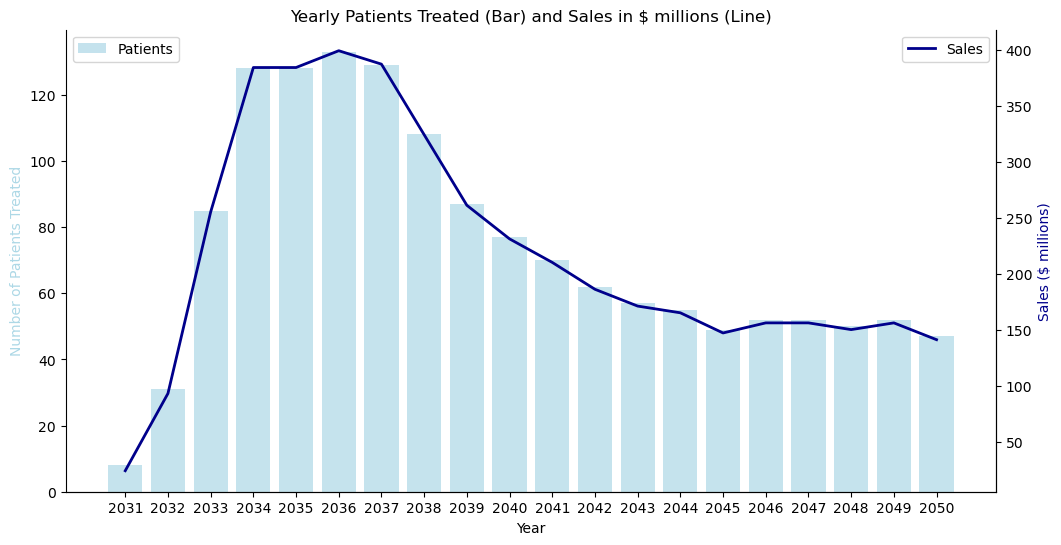

In [74]:
# Calculate projections
sales_projection, patients_projection, total_treated = calculate_sales_and_patients(timeline, cost_per_treatment=3000000)

# Find peak sales year 
peak_year = max(sales_projection, key=sales_projection.get)
peak_sales = sales_projection[peak_year]
peak_patients = patients_projection[peak_year]

print(f"\nSales and Patient Projection ($3,000,000 per treatment)")
print("-" * 70)
print(f"Peak year: {peak_year}")
print(f"Peak sales amount: ${peak_sales:,}")
print(f"Peak patients treated: {peak_patients:,}")
print(f"Total patients treated by 2050: {total_treated:,}")
print("\nYearly Projection:")
print(f"{'Year':<6}{'Patients':<10}{'Sales':>15}")
print("-" * 31)
for year, sales in sorted(sales_projection.items()):
    patients = patients_projection[year]
    print(f"{year:<6}{patients:<10}${sales:>14,}")

# Create lists for plotting
years = sorted(sales_projection.keys())
patients = [patients_projection[year] for year in years]
sales = [sales_projection[year]/1000000 for year in years] # Convert to millions

# Create figure with secondary y-axis
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

# Plot bars and line
bars = ax1.bar(years, patients, color='lightblue', alpha=0.7)
line = ax2.plot(years, sales, color='darkblue', linewidth=2)

# Customize axes
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Patients Treated', color='lightblue')
ax2.set_ylabel('Sales ($ millions)', color='darkblue')

# Remove top and left spines
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Center x-ticks on bars
ax1.set_xticks(years)

# Set title
plt.title('Yearly Patients Treated (Bar) and Sales in $ millions (Line)')

# Add legend
ax1.legend(bars, ['Patients'], loc='upper left')
ax2.legend(line, ['Sales'], loc='upper right')

# Set transparent background
fig.patch.set_alpha(0)
ax1.patch.set_alpha(0)

# Save plot with transparent background
plt.savefig('output_data/sales_and_patients_projection.png', transparent=True, bbox_inches='tight', dpi=300)

# Display the plot
plt.show()

In [56]:
# Get regional breakdown and add total
regional_patients = timeline[
    (timeline['year'] == 2025) & 
    (timeline['alive'] == True)
].groupby('region').size().reset_index(name='patients')

# Add total row
total_row = pd.DataFrame({'region': ['Total'], 'patients': [regional_patients['patients'].sum()]})
regional_patients = pd.concat([regional_patients, total_row])

# Copy to clipboard
regional_patients.to_clipboard(index=False)

regional_patients


,region,patients
0,Africa,1438
1,Americas,999
2,Asia,4083
3,Europe,542
4,Oceania,37
0,Total,7099


In [14]:
timeline = pd.read_csv('/Users/smeden/Desktop/Lowe Syndrome Collaborative/Walther Therapeutics/git/Models/populationsdata/Simulated_ls_pop_1950_2060.csv')

# Create choropleth map of alive patients per country in 2025
patients_2025 = timeline[
    (timeline['year'] == 2025) & 
    (timeline['alive'] == True)
].groupby('iso3').size().reset_index(name='patients')
# Downward adjust all African numbers by 50%
patients_2025.loc[patients_2025['iso3'].isin(
    timeline.loc[timeline['region'] == 'Africa', 'iso3'].unique()
),'patients'] *=0.25
# Get the top 3 countries by patient count
top_3_countries = patients_2025.nlargest(3, 'patients')

# Cap values at 100+ for better visualization
patients_2025['patients_capped'] = patients_2025['patients'].clip(upper=100)

# Create the choropleth map
fig = px.choropleth(
    patients_2025,
    locations='iso3',
    color='patients_capped',
    hover_name='iso3',
    color_continuous_scale=["#FFFFFF", "#2F6CD6"],  # White to dark blue
    range_color=[0, 100],
    labels={'patients_capped': 'Number of Patients'},
    title='Alive Patients per Country in 2025 (Values capped at 100+)'
)

# Update layout
fig.update_layout(
    title_x=0.5,
    geo=dict(showframe=False, showcoastlines=True, projection_type='equirectangular'),
    width=1000,
    height=600,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

# Save figure to output_data folder with transparent background
fig.write_image("output_data/patients_2025_choropleth.png", scale=4, engine="kaleido")

fig.show()


In [ ]:
import os, io
import pandas as pd, numpy as np
import plotly.graph_objects as go
import plotly.io as pio
from PIL import Image

# --- Load & prepare 2025 snapshot (kept your logic) ---
timeline = pd.read_csv('/Users/smeden/Desktop/Lowe Syndrome Collaborative/Walther Therapeutics/git/Models/populationsdata/Simulated_ls_pop_1950_2060.csv')

patients_2025 = (timeline[(timeline['year'] == 2025) & (timeline['alive'] == True)]
                 .groupby('iso3').size().reset_index(name='patients'))

# Downward adjust Africa by 75% (your original 0.25). Use 0.5 if you truly want 50%.
afr_iso3 = timeline.loc[timeline['region'] == 'Africa', 'iso3'].unique()
patients_2025.loc[patients_2025['iso3'].isin(afr_iso3), 'patients'] *= 0.25

patients_2025['patients_capped'] = patients_2025['patients'].clip(upper=100)

# --- Build static choropleth background ---
fig = go.Figure()

fig.add_trace(go.Choropleth(
    locations=patients_2025['iso3'],
    z=patients_2025['patients_capped'],
    colorscale=[ [0.0, "#FFFFFF"], [1.0, "#2F6CD6"] ],
    zmin=0, zmax=100,
    colorbar_title="Patients (≤100+)",
    marker_line_width=0.2,
    marker_line_color="rgba(0,0,0,0.35)",
    hovertemplate="<b>%{location}</b><br>Patients (capped): %{z}<extra></extra>"
))

# --- Sequence of pins in your speaking order (labels in Danish) ---
sequence = [
    {"label": "Willum",      "lat": 56.1629, "lon": 10.2039},
    {"label": "Nicklas",     "lat": 57.3705, "lon": 9.7135},
    {"label": "David",           "lat": 59.9139, "lon": 10.7522},
    {"label": "Blake",       "lat": 39.1031, "lon": -84.5120},
    {"label": "Luca", "lat": 51.5074, "lon": -0.1278},
    {"label": "José",     "lat": 38.7223, "lon": -9.1393},
]

script_lines = [
    "Walther er ikke alene i Danmark.",
    "Han deler sin dagligdag med Willum i Aarhus.",
    "Nicklas i Løkken.",
    "David i Oslo.",
    "Blake i Cincinnati.",
    "Luca i London, José i Portugal.",
    "… og knap 7.000 andre drenge globalt.",
]

# Empty scatter trace that frames will update
fig.add_trace(go.Scattergeo(
    lat=[], lon=[], mode="markers+text", text=[],
    textposition="top center",
    textfont=dict(size=12),
    marker=dict(size=[], color=[], line=dict(width=1, color="white")),
    hoverinfo="text", showlegend=False
))

# --- Build frames (cumulative reveal; newest point highlighted) ---
frames = []
for i in range(1, len(sequence) + 1):
    lats  = [p["lat"] for p in sequence[:i]]
    lons  = [p["lon"] for p in sequence[:i]]
    texts = [p["label"] for p in sequence[:i]]
    sizes = [12]*(i-1) + [20]                      # newest = larger
    colors= ["rgba(120,120,120,0.55)"]*(i-1) + ["rgba(47,108,214,1)"]  # newest = blue

    frames.append(go.Frame(
        name=f"step{i}",
        data=[go.Scattergeo(
            lat=lats, lon=lons, text=texts, mode="markers+text",
            textposition="top center",
            textfont=dict(size=12),
            marker=dict(size=sizes, color=colors, line=dict(width=1, color="white")),
            hoverinfo="text"
        )]
        )
    ))

# Final frame: same pins, big concluding line
lats  = [p["lat"] for p in sequence]
lons  = [p["lon"] for p in sequence]
texts = [p["label"] for p in sequence]
sizes = [12]*len(sequence)
colors= ["rgba(120,120,120,0.75)"]*len(sequence)

frames.append(go.Frame(
    name="final",
    data=[go.Scattergeo(
        lat=lats, lon=lons, text=texts, mode="markers+text",
        textposition="top center",
        textfont=dict(size=12),
        marker=dict(size=sizes, color=colors, line=dict(width=1, color="white")),
        hoverinfo="text"
    )]
    )
))

fig.frames = frames

# --- Layout & controls ---
fig.update_layout(
    title={'text': 'Alive patients per country in 2025 (values capped at 100+)', 'x': 0.5},
    geo=dict(
        showframe=False, showcoastlines=True, projection_type='equirectangular',
    ),
    width=1000, height=600,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    margin=dict(l=0, r=0, t=60, b=0),
    updatemenus=[dict(
        type="buttons", showactive=False, x=0.02, y=0.95, xanchor="left",
        buttons=[dict(
            label="▶︎ Play",
            method="animate",
            args=[None, {"frame": {"duration": 800, "redraw": True},
                         "transition": {"duration": 250},
                         "fromcurrent": True}]
        )]
    )]
)

# Optional: initial annotation (before play)
fig.update_layout(annotations=[dict(
    x=0.02, y=0.06, xref="paper", yref="paper",
    bgcolor="rgba(255,255,255,0.75)", bordercolor="rgba(0,0,0,0.2)", borderwidth=0.5,
    font=dict(size=14)
)])

# --- Save static PNG (as you already do) ---
os.makedirs("output_data", exist_ok=True)
pio.write_image(fig, "output_data/patients_2025_choropleth_with_sequence.png", scale=4, engine="kaleido")

# --- Save interactive HTML (handy for rehearsals) ---
pio.write_html(fig, file="output_data/patients_sequence.html", auto_open=False, include_plotlyjs="cdn")

# --- Export a GIF for Keynote/PowerPoint ---
images = []
# Build a figure for each frame combining the static map + frame pins
for fr in fig.frames:
    f = go.Figure(data=fig.data, layout=fig.layout)
    # scatter trace is at index 1
    f.data[1].update(fr.data[0])
    if hasattr(fr, "layout") and getattr(fr.layout, "annotations", None):
        f.update_layout(annotations=fr.layout.annotations)
    png = pio.to_image(f, format="png", width=1280, height=720, scale=2, engine="kaleido")
    images.append(Image.open(io.BytesIO(png)))

images[0].save("output_data/patients_sequence.gif",
               save_all=True, append_images=images[1:], duration=800, loop=0)
print("Saved: output_data/patients_sequence.gif and patients_sequence.html")


Saved: output_data/patients_sequence.gif and patients_sequence.html


In [ ]:
import os, io, re
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from PIL import Image

# --- Load your 2025 snapshot (incl. Africa adjustment) ---
timeline = pd.read_csv('/Users/smeden/Desktop/Lowe Syndrome Collaborative/Walther Therapeutics/git/Models/populationsdata/Simulated_ls_pop_1950_2060.csv')
patients_2025 = (timeline[(timeline['year'] == 2025) & (timeline['alive'] == True)]
                 .groupby('iso3').size().reset_index(name='patients'))

afr_iso3 = timeline.loc[timeline['region'] == 'Africa', 'iso3'].unique()
patients_2025.loc[patients_2025['iso3'].isin(afr_iso3), 'patients'] *= 0.25
patients_2025['patients_capped'] = patients_2025['patients'].clip(upper=100)

# --- Your line, split into beats (DK x3, NOR, USA, GBR, PRT, GLOBAL) ---
text_beats = [
    "Walther er ikke alene.",
    "Han deler sin dagligdag med Willum i Aarhus.",
    "Nicklas i Løkken.",
    "David i Oslo.",
    "Blake i Cincinnati.",
    "Luca i London,",
    "José i Portugal",
    "og knap 7.000 drenge globalt."
]
# Country steps aligned with beats; [] = no new country (stay on DK)
country_steps = [
    ["DNK"], [], [],           # Denmark x3 (faster beats)
    ["NOR"], ["USA"],          # Norway, USA
    ["GBR"], ["PRT"],          # UK, then Portugal (separate)
    "GLOBAL"                   # final global reveal
]

# --- Duration model: shorter for early DK beats, normal for others ---
def word_count(s: str) -> int:
    s = re.sub(r'(?<=\d)[\.\s](?=\d{3}\b)', '', s)  # 7.000 -> 7000
    return len(re.findall(r'\b\w+[’\w]*\b', s))

WPM = 130                 # base speaking pace (slightly brisk)
EXTRA_PAUSE_MS = 250      # small buffer per beat
SCALE = [0.70, 0.80, 0.90, 1.00, 1.00, 1.00, 1.00, 1.10]  # speed DK, linger a touch on final
MIN_MS = 800              # avoid too-quick flashes

base_ms = [ (word_count(t)/WPM)*60_000 + EXTRA_PAUSE_MS for t in text_beats ]
durations_ms = [ int(max(MIN_MS, round(b*s))) for b, s in zip(base_ms, SCALE) ]

print("Per-beat durations (ms):", durations_ms, "Total ≈", sum(durations_ms)/1000, "s")

# --- Build the unlabeled choropleth frames ---
fig = go.Figure()
fig.add_trace(go.Choropleth(
    locations=[], z=[],
    showscale=False,
    colorscale=[[0, "#2F6CD6"], [1, "#2F6CD6"]],
    marker_line_width=0.6, marker_line_color="white",
    hoverinfo="skip"
))
fig.update_geos(
    showframe=False, showcoastlines=False, showcountries=False, showland=False,
    projection_type='equirectangular', bgcolor='rgba(0,0,0,0)'
)
fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    showlegend=False
)

# Cumulative highlights with separate UK then Portugal
frames, cumulative = [], []
for step in country_steps:
    if step == "GLOBAL":
        frames.append(go.Frame(data=[go.Choropleth(
            locations=patients_2025['iso3'],
            z=patients_2025['patients_capped'],
            showscale=False,
            colorscale=[[0.0, "#FFFFFF"], [1.0, "#2F6CD6"]],
            zmin=0, zmax=100,
            marker_line_width=0.2, marker_line_color="white",
            hoverinfo="skip"
        )]))
    else:
        for c in step:
            if c not in cumulative:
                cumulative.append(c)
        frames.append(go.Frame(data=[go.Choropleth(
            locations=cumulative, z=[1]*len(cumulative),
            showscale=False,
            colorscale=[[0, "#2F6CD6"], [1, "#2F6CD6"]],
            marker_line_width=0.6, marker_line_color="white",
            hoverinfo="skip"
        )]))

fig.frames = frames

# --- Export GIF with the tuned durations ---
os.makedirs("output_data", exist_ok=True)
images = []
for fr in fig.frames:
    f = go.Figure(data=fr.data, layout=fig.layout)  # fresh fig per frame
    png = pio.to_image(f, format="png", width=1600, height=900, scale=2, engine="kaleido")
    images.append(Image.open(io.BytesIO(png)))

images[0].save(
    "output_data/patients_sequence_unlabeled_tuned.gif",
    save_all=True, append_images=images[1:], duration=durations_ms, loop=0
)
print("Saved: output_data/patients_sequence_unlabeled_tuned.gif")


Per-beat durations (ms): [1467, 3154, 1471, 1635, 1635, 1635, 1635, 2813] Total ≈ 15.445 s
Saved: output_data/patients_sequence_unlabeled_tuned.gif


In [6]:
"""
Soft rolling blue wave across Funen (Fyn), Denmark.
Outputs MP4 (preferred for Keynote/PPT) with GIF fallback.

Requires: shapely, matplotlib, numpy, requests, imageio, imageio-ffmpeg
Install (example):
  pip install shapely matplotlib numpy requests imageio imageio-ffmpeg
"""

import math
import numpy as np
import requests
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.colors import LinearSegmentedColormap
from shapely.geometry import shape, Polygon, MultiPolygon
from shapely.ops import unary_union
import imageio  # v2 API for mp4 writer
import imageio.v3 as iio

# ---------------------- KNOBS ----------------------
BRAND_BLUE      = "#2F6CD6"
WIDTH_PX        = 1400      # output width (pixels)
TOTAL_SECONDS   = 8         # one full left→right pass length
FPS             = 20        # smooth playback
CYCLES_PER_LOOP = 1.0       # passes per loop (1 = one sweep)
BAND_WIDTH      = 0.28      # half-width of bright band (0..0.5)
BACKGROUND_LVL  = 0.33      # baseline outside the band (0..1)
OUT_MP4         = "funen_roll_soft.mp4"
OUT_GIF         = "funen_roll_soft.gif"
# ---------------------------------------------------

def fetch_osm_geojson(name: str):
    """Fetch polygon GeoJSON via Nominatim and return shapely geometry."""
    url = "https://nominatim.openstreetmap.org/search"
    params = {"q": name, "format": "geojson", "polygon_geojson": 1, "limit": 10}
    headers = {"User-Agent": "fyn-rolling-gradient/1.0 (non-commercial)"}
    r = requests.get(url, params=params, headers=headers, timeout=30)
    r.raise_for_status()
    fc = r.json()
    best, best_area = None, -1
    for feat in fc.get("features", []):
        geom = feat.get("geometry")
        if not geom:
            continue
        try:
            g = shape(geom)
        except Exception:
            continue
        a = abs(g.area)
        if a > best_area:
            best, best_area = g, a
    if best is None:
        raise RuntimeError(f"No polygon found for query: {name}")
    return unary_union(best.buffer(0))  # fix tiny topology issues

def to_clip_path(geom):
    """Convert shapely (Multi)Polygon to a Matplotlib compound Path."""
    def ring_to_path(ring):
        v = np.asarray(ring.coords)
        codes = np.full(len(v), Path.LINETO, dtype=np.uint8)
        codes[0] = Path.MOVETO
        verts = np.vstack([v, v[0]])
        codes = np.append(codes, Path.CLOSEPOLY)
        return Path(verts, codes)
    if isinstance(geom, Polygon):
        parts = [ring_to_path(geom.exterior)] + [ring_to_path(i) for i in geom.interiors]
        return Path.make_compound_path(*parts)
    if isinstance(geom, MultiPolygon):
        all_parts = []
        for p in geom.geoms:
            all_parts.append(ring_to_path(p.exterior))
            all_parts.extend(ring_to_path(i) for i in p.interiors)
        return Path.make_compound_path(*all_parts)
    raise ValueError("Unsupported geometry for clip path")

def rolling_field_soft(W, H, phase, width=BAND_WIDTH, background=BACKGROUND_LVL):
    """
    Soft moving band using a raised-cosine (Hann) window that wraps horizontally.
    - width: half-width of the bright band as a fraction of width (0..0.5)
    - background: baseline intensity (0..1) outside the band
    """
    x = np.linspace(0, 1, W)
    center = phase % 1.0
    # circular distance on [0,1) → seamless softness at both edges
    dist = np.abs((x - center + 0.5) % 1.0 - 0.5)
    # raised-cosine window (1 at center → 0 at |dist| >= width)
    win = 0.5 * (1 + np.cos(np.pi * np.clip(dist / max(width, 1e-6), 0, 1)))
    band = background + (1 - background) * win
    return np.tile(band, (H, 1))

def main():
    # 1) Get Fyn polygon (fallback to “Funen” if needed)
    try:
        island = fetch_osm_geojson("Fyn, Denmark")
    except Exception:
        island = fetch_osm_geojson("Funen, Denmark")

    minx, miny, maxx, maxy = island.bounds
    aspect = (maxy - miny) / (maxx - minx)
    W = int(WIDTH_PX)
    H = max(1, int(aspect * W))
    clip_path = to_clip_path(island)

    # 2) Brand-blue monochrome colormap (white → #2F6CD6)
    cmap = LinearSegmentedColormap.from_list("brandblue", ["#ffffff", BRAND_BLUE])

    # 3) Prepare exact-pixel canvas (no margins)
    dpi = 100
    fig = plt.figure(figsize=(W / dpi, H / dpi), dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1])  # fill figure, no axes
    ax.set_axis_off()

    # 4) Render frames
    num_frames = int(TOTAL_SECONDS * FPS)
    frames = []
    for i in range(num_frames):
        phase = CYCLES_PER_LOOP * (i / num_frames)  # increases → left→right
        img = rolling_field_soft(W, H, phase)

        ax.clear()
        ax.set_axis_off()
        im = ax.imshow(
            img,
            extent=[minx, maxx, miny, maxy],
            origin="lower",
            cmap=cmap,
            vmin=0.25, vmax=1.0,       # keep it mostly blue
            interpolation="bicubic",   # extra smooth
        )
        im.set_clip_path(PathPatch(clip_path, transform=ax.transData))
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)

        # subtle white outline (helps on dark slides)
        try:
            for g in getattr(island, "geoms", [island]):
                xs, ys = g.exterior.xy
                ax.plot(xs, ys, linewidth=0.9, color="white", alpha=0.9)
        except Exception:
            pass

        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        frame = frame.reshape(H, W, 3)
        frames.append(frame)

    plt.close(fig)

    # 5) Write MP4 (preferred). Fallback to GIF if ffmpeg is missing.
    try:
        with imageio.get_writer(
            OUT_MP4, fps=FPS, codec="libx264", macro_block_size=None
        ) as w:
            for fr in frames:
                w.append_data(fr)
        print(f"Wrote {OUT_MP4}")
    except Exception as e:
        print(f"MP4 export failed ({e}). Writing GIF instead.")
        iio.imwrite(OUT_GIF, frames, duration=1 / FPS, loop=0)
        print(f"Wrote {OUT_GIF}")

if __name__ == "__main__":
    main()


MP4 export failed (TiffWriter.write() got an unexpected keyword argument 'fps'). Writing GIF instead.
Wrote funen_roll_soft.gif
